In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.vision.all import *
import sklearn.metrics as skm
from tqdm.notebook import tqdm
import sklearn.feature_extraction.text
from transformers import (BertTokenizer, BertModel,
                          DistilBertTokenizer, DistilBertModel)

In [3]:
import debugpy
debugpy.listen(5678)

('127.0.0.1', 5678)

In [4]:
from shopee_utils import *

In [20]:
PATH = Path('../input/shopee-product-matching')
model_file  = '../input/resnet-model/bert814.pth'
if not PATH.is_dir():
    PATH = Path('/home/slex/data/shopee')
    model_file ='models/bert814.pth'
BERT_PATH = './bert_indonesian'

In [6]:
train_df = pd.read_csv(PATH/'train_split.csv')
train_df['is_valid'] = train_df.split==0

In [21]:
#model_name='cahya/bert-base-indonesian-522M'
#model_name='cahya/distilbert-base-indonesian'

In [8]:
class ArcFaceClassifier(nn.Module):
    def __init__(self, in_features, output_classes):
        super().__init__()
        emb_dim=768
        mid_size = 512
        self.initial_layers=nn.Sequential(
#             nn.Linear(in_features, mid_size),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm1d(mid_size),
#             nn.Dropout(),
#             nn.Linear(mid_size,emb_dim),
            nn.BatchNorm1d(emb_dim),
            nn.Dropout(.25))
        self.W = nn.Parameter(torch.Tensor(emb_dim, output_classes))
        nn.init.kaiming_uniform_(self.W)
    def forward(self, x):
        x = self.initial_layers(x)
        x_norm = F.normalize(x)
        W_norm = F.normalize(self.W, dim=0)
        return x_norm @ W_norm
    
    
def arcface_loss(cosine, targ, m=.5, s=30):
    cosine = cosine.clip(-1+1e-7, 1-1e-7) 
    arcosine = cosine.arccos()
    arcosine += F.one_hot(targ, num_classes = dls.c) * m
    cosine2 = arcosine.cos()
    cosine2 *= s
    return F.cross_entropy(cosine2, targ)

In [9]:
class BertArcFace(nn.Module):
    def __init__(self, bert_model):
        super().__init__()
        self.bert_model = bert_model
        self.classifier = ArcFaceClassifier(768, dls.c)
        self.outputEmbs = False
    def forward(self, x):
        output = self.bert_model(*x)
        embeddings = output.last_hidden_state[:,0,:]#output.pooler_output
        if self.outputEmbs:
            return embeddings
        return self.classifier(embeddings)


In [10]:
class TitleTransform(Transform):
    def __init__(self):
        super().__init__()
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        
        
    def encodes(self, row):
        text = row.title
        encodings = self.tokenizer(text, padding = 'max_length', max_length=50, truncation=True,return_tensors='pt')
        keys =['input_ids', 'attention_mask', 'token_type_ids'] 
        return tuple(encodings[key].squeeze() for key in keys)

In [11]:
tfm = TitleTransform()

data_block = DataBlock(
    blocks = (TransformBlock(type_tfms=tfm), 
              CategoryBlock(vocab=train_df.label_group.to_list())),
    splitter=ColSplitter(),
    get_y=ColReader('label_group'),
    )
dls = data_block.dataloaders(train_df, bs=256,num_workers=16)


In [12]:
def do_chunk(embs):
    step = 10000
    for chunk_start in range(0, embs.shape[0], step):
        chunk_end = min(chunk_start+step, len(embs))
        yield embs[chunk_start:chunk_end]

In [23]:
def new_model():
    bert_model = BertModel.from_pretrained(BERT_PATH)
    return BertArcFace(bert_model)

In [14]:
def split_3way(model):
    return L(params(model.bert_model.embeddings),
            params(model.bert_model.encoder) + params(model.bert_model.pooler), 
            params(model.classifier))
def split_2way(model):
    return L(params(model.bert_model),
            params(model.classifier))

In [15]:
def count_params(parameters):
    res =0 
    for p in parameters:
        res+=p.numel()
    return res

# count_params(learn.model.parameters())

# splitted = split_2way(learn.model)
# parts =[count_params(m) /1e6 for m in splitted]
# print(parts, sum(parts))

In [16]:
def f1_from_embs(embs, ys):
    target_matrix = ys[:,None]==ys[None,:]
    groups = [torch.where(t)[0].tolist() for t in target_matrix]
    dists, inds = get_nearest(embs, do_chunk(embs))
    pairs = sorted_pairs(dists, inds)[:len(embs)*10]
    scores =build_from_pairs(pairs, groups, False)
    return max(scores)

In [17]:
class F1FromEmbs(Callback):
    def after_pred(self):
        if not self.training:
            self.embs.append(self.learn.pred)
            self.ys.append(self.learn.yb[0])
            self.learn.yb = tuple()
    def before_validate(self):
        self.ys = []
        self.embs = []
        self.model.outputEmbs = True
    def before_train(self):
        self.model.outputEmbs = False
    def after_validate(self):
        embs = torch.cat(self.embs)
        ys = torch.cat(self.ys)
        score = f1_from_embs(embs,ys)
        learn.metrics[0].val = score

class FakeMetric(Metric):
    val =0.0
    @property
    def value(self):
        return self.val
    
    @property
    def name(self): 
        return 'F1 embeddings'

In [24]:
learn = Learner(dls,new_model(),  splitter=split_2way, loss_func=arcface_loss,  cbs = F1FromEmbs, metrics=FakeMetric())

In [25]:
learn.fine_tune(8, 1e-2, freeze_epochs=2)

epoch,train_loss,valid_loss,F1 embeddings,time
0,21.281075,None,0.705796,00:34
1,16.533262,None,0.758955,00:34


epoch,train_loss,valid_loss,F1 embeddings,time
0,12.433543,None,0.795079,00:48
1,11.145361,None,0.809990,00:47
2,9.832925,None,0.817589,00:48
3,8.245600,None,0.819631,00:48
4,6.840007,None,0.820883,00:48
5,5.681211,None,0.822333,00:48
6,4.862615,None,0.822817,00:48
7,4.457173,None,0.823062,00:48


In [ ]:
learn.load('bert823val')

In [26]:
learn.save('bert823val')

Path('models/bert823val.pth')

## Validataion set

In [30]:
embs_model = learn.model.eval()
embs_model.out

In [31]:
valid_embs, _ = embs_from_model(embs_model, dls.valid)

  0%|          | 0/27 [00:00<?, ?it/s]

In [32]:
dists, inds = get_nearest(valid_embs, do_chunk(valid_embs))

In [33]:
valid_df=train_df[train_df.is_valid==True].copy().reset_index()
valid_df = add_target_groups(valid_df)

In [34]:
pairs = sorted_pairs(dists, inds)[:len(valid_df)*10]

0.815 at 6.250881195068359 pairs


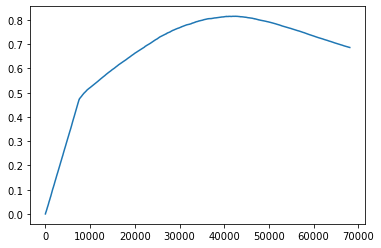

In [35]:
_=build_from_pairs(pairs, valid_df.target.to_list())